# Covid19 USA States

In [1]:
import sys
import os
from qgis.core import *
from qgis.PyQt.QtGui import *
from qgis.PyQt.QtCore import *

Starting qgis application

In [2]:
QgsApplication.setPrefixPath(r'C:\\OSGeo4W64\\apps\\qgis', True)
qgs = QgsApplication([], True)
qgs.initQgis()
sys.path.append(r'C:\OSGeo4W64\apps\qgis\python\plugins')

In [3]:
project = QgsProject.instance()

Load shapefile of USA States

In [4]:
# load map layer
usa_path = "/vsizip/data/usa_states_map/tl_2017_us_state.zip"
usa_layer = QgsVectorLayer(usa_path, 'USA States Map', 'ogr')

if not usa_layer.isValid():
    print("Failed to load the layer!")

Load csv file of covid19 data and create a vector layer

In [5]:
# load covid-19 numbers 04-25-2020
covid_path = "file:///E:/TA-Cartografia/data/covid19-usa/04-25-2020.csv"
covid_layer = QgsVectorLayer(covid_path, 'covid19', 'delimitedtext')

if not covid_layer.isValid():
    print('Layer failed to load!')

In [6]:
project.addMapLayer(usa_layer)
project.addMapLayer(covid_layer)

<QgsMapLayer: 'covid19' (delimitedtext)>

Pie chart with the numbers of 

In [7]:
import matplotlib.pyplot as plt

In [8]:
top = 5
confirmed = {}

total_id = 60
states = QgsExpression("Province_State != 'Recovered'")

for feature in covid_layer.getFeatures(QgsFeatureRequest(states)):
    confirmed[feature['Province_State']] = int(feature['Confirmed'])

initial = confirmed.copy()

In [9]:
total = sum(confirmed.values())
confirmed = {k: v for k, v in sorted(confirmed.items(), key=lambda item: item[1], reverse=True)[:top]}
confirmed['Remaining'] = total - sum(confirmed.values())

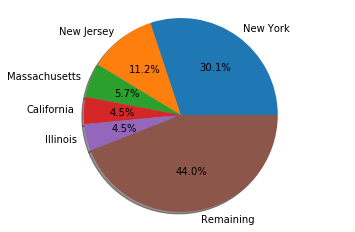

In [10]:
plt.pie(confirmed.values(), shadow=True, labels=confirmed.keys(), autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [12]:
usaField = 'NAME'
covidField = 'Province_State'
joinObject = QgsVectorLayerJoinInfo()
joinObject.setJoinFieldName(covidField)
joinObject.setTargetFieldName(usaField)
joinObject.setJoinLayerId(covid_layer.id())
joinObject.setUsingMemoryCache(True)
joinObject.setJoinLayer(covid_layer)
usa_layer.addJoin(joinObject)

True

Add new field to the layer, once covid19-usa_Confirmed attribute is a string

In [21]:
target_field = 'covid19_Confirmed'
myRangeList = []

symbol = QgsSymbol.defaultSymbol(usa_layer.geometryType())     
symbol.setColor(QColor(200, 20, 20))                              
myRange = QgsRendererRange(0, 5000, symbol, 'Group 1')
myRangeList.append(myRange)

symbol = QgsSymbol.defaultSymbol(usa_layer.geometryType())
symbol.setColor(QColor(150, 20, 20))
myRange = QgsRendererRange(5001, 50000, symbol, 'Group 2')
myRangeList.append(myRange)

symbol = QgsSymbol.defaultSymbol(usa_layer.geometryType())
symbol.setColor(QColor(100, 20, 20))
myRange = QgsRendererRange(50001, 500000, symbol, 'Group 3')
myRangeList.append(myRange)

myRenderer = QgsGraduatedSymbolRenderer(target_field, myRangeList)
myRenderer.setMode(QgsGraduatedSymbolRenderer.Custom)               

usa_layer.setRenderer(myRenderer)

C:\OSGEO4~1\apps\Python37\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: QgsGraduatedSymbolRenderer.setMode() is deprecated


In [22]:
xt = usa_layer.extent()
# print(xt)
width  = 1000
height = int(width*xt.height()/xt.width())
print("Gerar mapa com {} por {}".format(width, height))

options = QgsMapSettings()
options.setLayers([usa_layer])
options.setBackgroundColor(QColor(255, 255, 255))
options.setOutputSize(QSize(width, height))
options.setExtent(xt)
           
render = QgsMapRendererParallelJob(options)
render.start()
render.waitForFinished()

image = render.renderedImage()

Gerar mapa com 1000 por 239


In [23]:
from IPython.display import Image

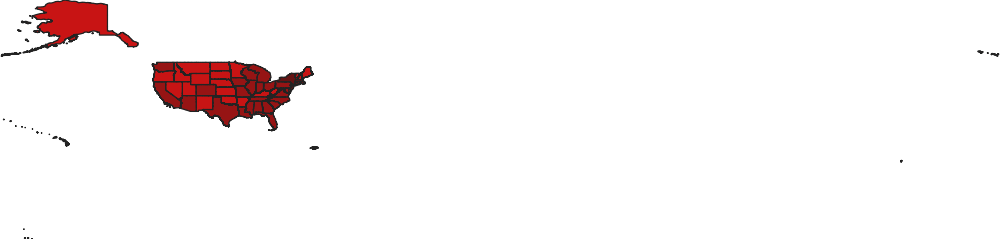

In [24]:
imgbuf= QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image.save( imgbuf,"PNG" )
Image( imgbuf.data() )

In [ ]:
qgs.exitQgis()